데이터 : 스마트폰, 이마, 색소침착 데이터<br>
모든 데이터를 넣었을 경우 하나의 등급으로 찍는 현상이 나타남<br>
 0등급과 2등급의 라벨만을 선발하여 모델이 이미지를 학습 할 수 있는지를 먼저 확인

In [64]:
import pdb # 디버깅코드 평가함수에 주석처리로 포함
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import pickle
import cv2

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [67]:
# 학습 데이터 준비 1. 스마트폰, 전면, 이마, 메타데이터 전체
path = "/content/drive/MyDrive/Human_Final_Project/Data/250202_전체데이터/Camera_Train_Data_Set.pkl"
with open(path, "rb") as pickle_file:
    train_data_sets = pickle.load(pickle_file)
    print("데이터 로드 완료!!")

데이터 로드 완료!!


In [68]:
def data_selector(data_sets, target):
    """
    data_sets : {'Images': dict, 'Metadata': dict}
    target : [0, 2] 리스트형식으로 입력
    """

    # 원하는 타겟의 파일이름을 저장하기 위한 리스트 생성
    keys = []
    for idx, file_name in enumerate(data_sets["Metadata"]):
        pig = data_sets["Metadata"][file_name]['annotations']['forehead_pigmentation']
        # 타겟리스트안에 있는 파일명만 키에 저장
        if pig in target:
            keys.append(file_name)

    #값을 저장할 딕셔너리 생성
    selected_data = {}
    image = {}
    meta = {}

    #앞에서 생성한 키를 이용하여 데이터셋에서 파일명에 해당하는 데이터 추출
    for id in keys:
        image[id] = data_sets["Images"][id]
        meta[id] = data_sets["Metadata"][id]
    selected_data["Images"] = image
    selected_data["Metadata"] = meta

    from collections import Counter

    # 전체 데이터셋의 타겟 분포 확인
    targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in selected_data["Metadata"].values()]
    target_distribution = Counter(targets)

    # 분포 출력
    print("Target Distribution (Class Count):")
    for target, count in sorted(target_distribution.items()):
        print(f"Class {target}: {count}")

    classes = sorted(target_distribution.keys())
    counts = [target_distribution[c] for c in classes]

    plt.bar(classes, counts, tick_label=[f"Class {c}" for c in classes])
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Target Distribution")
    plt.show()

    return selected_data

Target Distribution (Class Count):
Class 0: 175
Class 2: 163


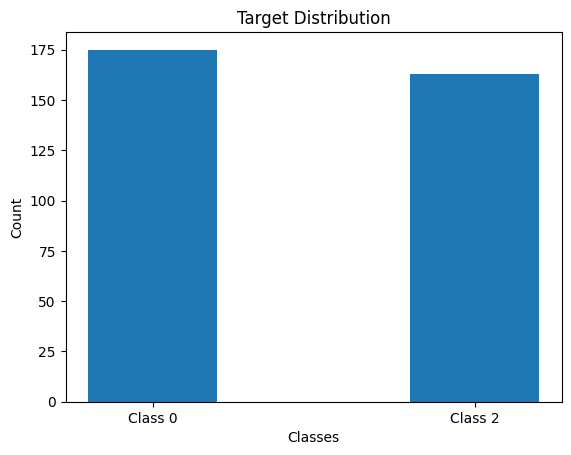

In [69]:
train_data = data_selector(train_data_sets, [0, 2])

In [70]:
# 검증 데이터 준비 1. 스마트폰, 전면, 이마, 메타데이터 전체
path = "/content/drive/MyDrive/Human_Final_Project/Data/250202_전체데이터/Camera_Val_Data_Set.pkl"
with open(path, "rb") as pickle_file:
    val_data_sets = pickle.load(pickle_file)
    print("데이터 로드 완료!!")

데이터 로드 완료!!


Target Distribution (Class Count):
Class 0: 21
Class 2: 21


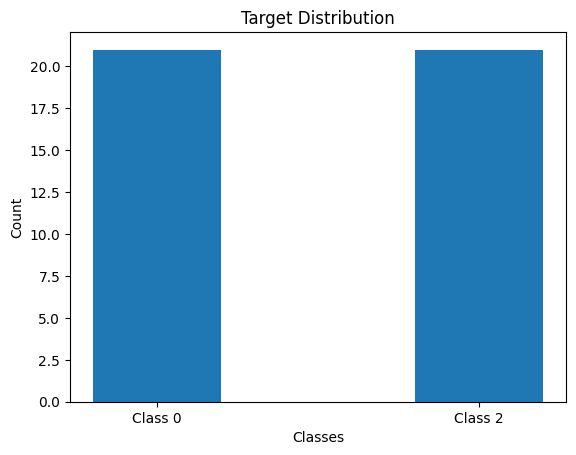

In [71]:
val_data = data_selector(val_data_sets, [0, 2])

In [72]:
# 데이터 준비 1.
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])

In [73]:
class CustomDataset(Dataset):
    def __init__(self, data_sets, transform=transform):
        """
        Args:
            data_sets (dict): {'Images': dict, 'Metadata': dict}
            transform (callable, optional): 이미지에 적용할 변환 함수
        """
        self.images = data_sets['Images']
        self.metadata = data_sets['Metadata']
        self.keys = list(self.images.keys())  # 공통 키 목록
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        image = self.images[key]

        # BGR에서 RGB로 변환
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        target = torch.tensor(self.metadata[key]['annotations']['forehead_pigmentation'], dtype=torch.float32)  # 타겟 텐서
        return image, target


In [74]:
#데이터셋 생성
dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)

In [81]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

In [76]:
# Model_01
"""
class SkinNet(nn.Module):
    def __init__(self):
        super(SkinNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.dropbout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # 수정된 입력 크기
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)  # Flatten the tensor

        x = F.relu(self.fc1(x))
        x = self.dropbout(x)

        x = F.relu(self.fc2(x))
        x = self.dropbout(x)

        x = self.fc3(x)
        return x
"""

In [85]:
# Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip_connection(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

# 수정된 SkinNet
class SkinNet(nn.Module):
    def __init__(self):
        super(SkinNet, self).__init__()

        # 초기 Conv 레이어
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Residual Blocks
        self.res_block1 = ResidualBlock(64, 128, stride=2)
        self.res_block2 = ResidualBlock(128, 256, stride=2)
        self.res_block3 = ResidualBlock(256, 512, stride=2)

        # Depthwise Separable Convolution
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, groups=512),  # Depthwise
            nn.Conv2d(512, 1024, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layers
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.depthwise_conv(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [86]:
model = SkinNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

print(model)

SkinNet(
  (initial_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (res_block1): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip_connection): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res_block2): Residua

In [ ]:
# 학습 함수
def train(model, train_loader, optimizer, criterion, device):
    loss_total = 0
    correct_total = 0
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # 누적 손실 및 정확도 계산
        loss_total += loss.item()
        predicted_values = output.max(1, keepdim=True)[1]
        correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
        correct_total += correct

    loss_total /= len(train_loader)  # 평균 손실
    accuracy = correct_total / len(train_loader.dataset)  # 정확도

    print(f"Epoch Finished - Loss: {loss_total:.4f}, Accuracy: {accuracy:.4f}")

    return loss_total, accuracy

In [ ]:
# 평가 함수
def evaluate(model, test_loader, criterion, device, val_dataset):
    loss_total = 0
    correct_total = 0
    model.eval()  # 평가 모드
    with torch.no_grad():  # 가중치 업데이트 비활성화
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss

            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total /= len(test_loader)  # 평균 손실
    accuracy = correct_total / len(val_dataset)  # 정확도

    return loss_total, accuracy

In [ ]:
# 손실 및 정확도 시각화
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import torch

# 히스토리 초기화
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# 최고 성능 초기값 설정
best_val_loss = float('inf')  # 손실 기준일 경우
# best_val_accuracy = 0.0     # 정확도 기준일 경우

# 학습 및 평가 실행
for epoch in range(100):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device, val_dataset)

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    # 최고 성능 모델 저장 (검증 손실 기준)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"🔥 Best model saved at epoch {epoch + 1} with val_loss: {val_loss:.4f}")

    # 정확도 기준으로 저장하고 싶다면 아래 주석 해제
    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     torch.save(model.state_dict(), 'best_model.pth')
    #     print(f"🚀 Best model saved at epoch {epoch + 1} with val_accuracy: {val_accuracy:.4f}")

    print(f"Epoch : {epoch + 1}, val_Loss: {val_loss:.4f}, val_Accuracy: {val_accuracy:.4f}\n")


Epoch Finished - Loss: 0.2100, Accuracy: 0.9320
🔥 Best model saved at epoch 1 with val_loss: 0.6453
Epoch : 1, val_Loss: 0.6453, val_Accuracy: 0.7381

Epoch Finished - Loss: 0.2541, Accuracy: 0.9083
🔥 Best model saved at epoch 2 with val_loss: 0.4237
Epoch : 2, val_Loss: 0.4237, val_Accuracy: 0.7857

Epoch Finished - Loss: 0.2514, Accuracy: 0.8994
Epoch : 3, val_Loss: 0.4605, val_Accuracy: 0.7381

Epoch Finished - Loss: 0.2211, Accuracy: 0.9260
🔥 Best model saved at epoch 4 with val_loss: 0.4120
Epoch : 4, val_Loss: 0.4120, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.1840, Accuracy: 0.9349
Epoch : 5, val_Loss: 0.4388, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.1933, Accuracy: 0.9467
🔥 Best model saved at epoch 6 with val_loss: 0.4078
Epoch : 6, val_Loss: 0.4078, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.2299, Accuracy: 0.9290
Epoch : 7, val_Loss: 0.5449, val_Accuracy: 0.8333

Epoch Finished - Loss: 0.2244, Accuracy: 0.9112
🔥 Best model saved at epoch 8 with val_loss: 0.3619

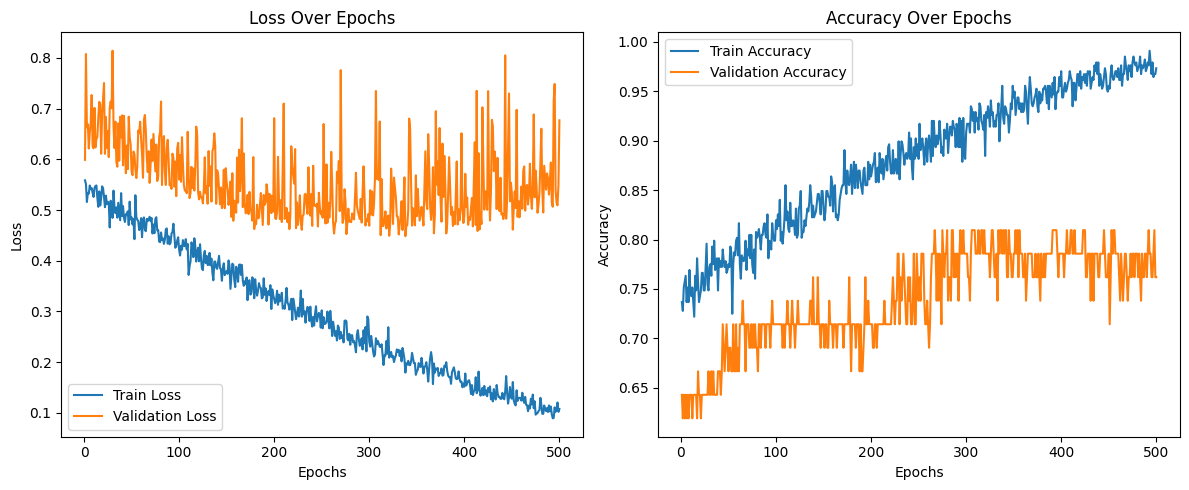

In [ ]:
# 학습 결과 시각화 스마트폰 Model_01 배치8 학습률 0.00001 에포크 500 -> model338_4579 (loss:0.45, acc:0.79)
plot_history(history)

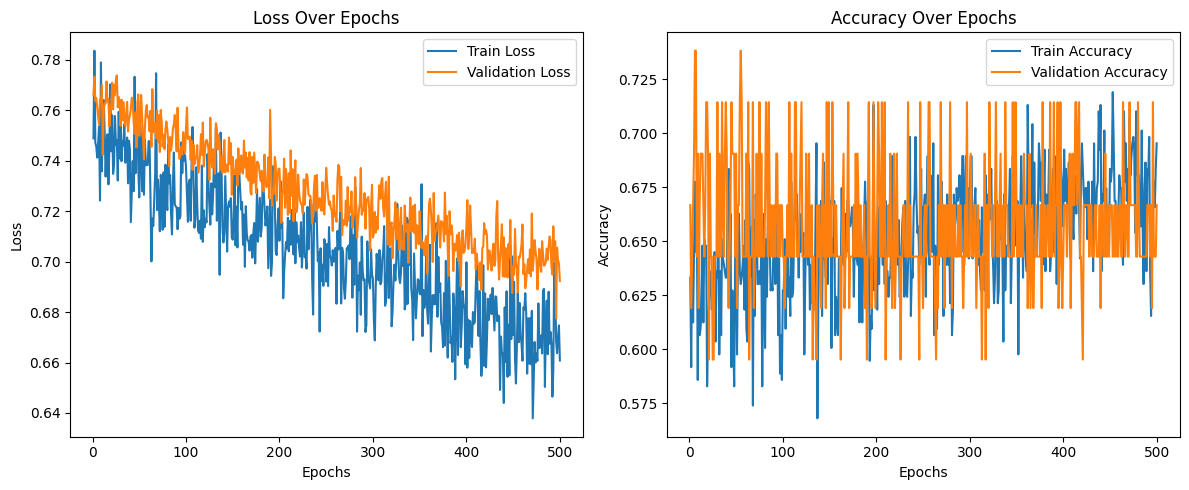

In [ ]:
# 학습 결과 시각화 스마트폰 Model_01 배치 8 학습률 0.00000001 에포크 1500 (loss:0.65, acc:0.64)
plot_history(history)

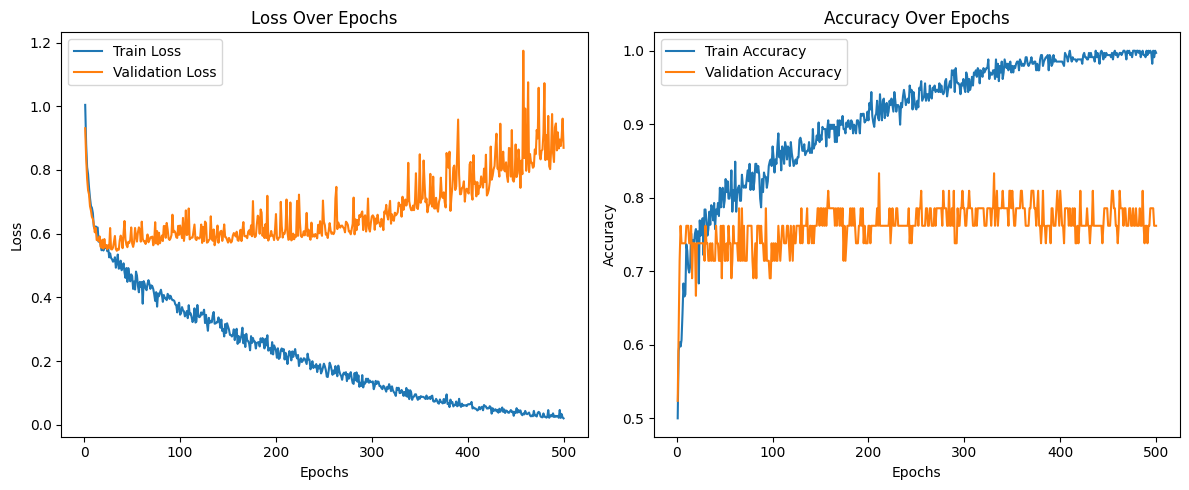

In [80]:
# 학습 결과 model_01, 시각화 디지털카메라 배치 4 학습률 0.000001 에포크 500
# Epoch : 034, val_Loss: 0.5462, val_Accuracy: 0.7143
# Epoch : 211, val_Loss: 0.7071, val_Accuracy: 0.8333
plot_history(history)

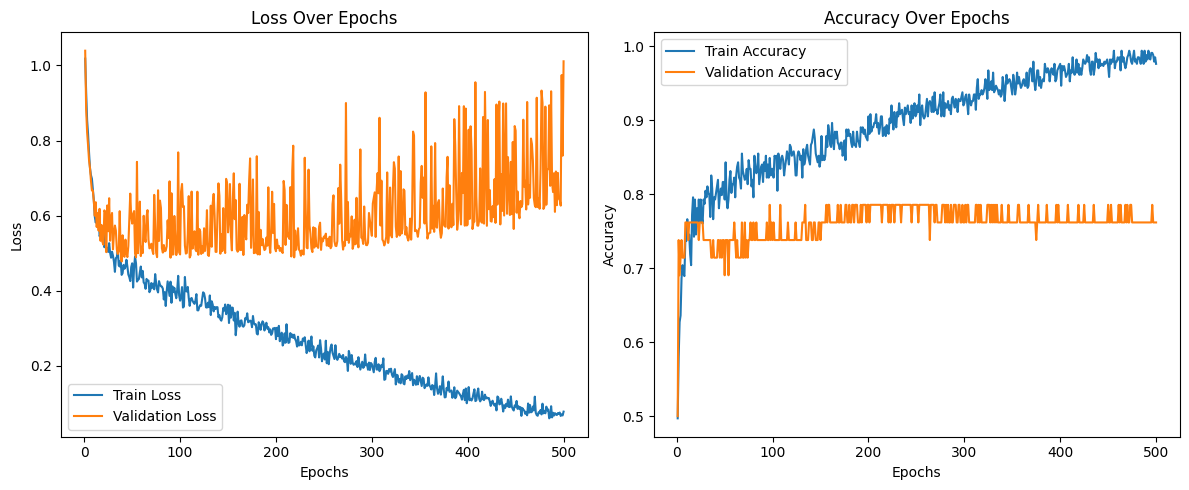

In [84]:
# 학습 결과 Model_02, 시각화 디지털카메라 배치 8 학습률 0.000001 에포크 300
# Epoch : 208, val_Loss: 0.3619, val_Accuracy: 0.7857
# Epoch : 256, val_Loss: 0.4308, val_Accuracy: 0.8333
plot_history(history)

In [ ]:
# 모델 전체 저장
torch.save(model, 'best_model_full.pth')

# 모델 전체 불러오기
model = torch.load('best_model_full.pth')
model.eval()

<ipython-input-21-ffdc0f1c562f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_full.pth')


SkinNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropbout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=